In [1]:
import os

os.environ["CHECKPOINTS_PATH"] = "../checkpoints"

import dataclasses
from src.api.services import sam2_service
import src.config
import torch
import gc
from torch.profiler import profile, record_function, ProfilerActivity, DeviceType

# Measure VRAM requirements of models

In [2]:
checkpoints = src.config.Sam2Checkpoints()
for name, path in dataclasses.asdict(checkpoints).items():
    with profile(activities=[ProfilerActivity.CUDA], profile_memory=True) as prof:
        with record_function(name):
            predictor = sam2_service.load_predictor(path)
            torch.cuda.synchronize()

    cpu_memory_events = [e for e in prof.events() if e.device_type == DeviceType.CPU]
    cpu_memory_events = sorted(cpu_memory_events, key=lambda e: e.time_range.start)
    print(cpu_memory_events[1].cpu_memory_usage)

    cuda_memory_events = [e for e in prof.events() if e.name == "[memory]"]
    cuda_memory_events = sorted(cuda_memory_events, key=lambda e: e.time_range.start)
    total_memory_usage = int(
        sum([e.self_cuda_memory_usage / (1024**2) for e in cuda_memory_events])
    )

    print(f"Checkpoint: {name}")
    print(f"Total memory usage: {total_memory_usage} MB")
    print("\n")

    del predictor
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()
    break

[W510 16:43:27.426201862 collection.cpp:979] Warning: Failed to recover relationship between all profiler and kineto events: 3899 vs. 0  reassociated. (function reassociate)


448
Checkpoint: BASE_PLUS
Total memory usage: 450 MB




/tmp/ipykernel_15517/1084037781.py:19: FutureWarning: `self_cuda_memory_usage` is deprecated. Use `self_device_memory_usage` instead.
  total_memory_usage = int(sum([e.self_cuda_memory_usage / (1024 ** 2) for e in cuda_memory_events]))


# Measure VRAM usage and tracking speed

In [11]:
from src.api.services import labeling_service
from src.api.db import Session, engine
from src.api.repositories import annotations_repo, simrooms_repo
import tempfile
from pathlib import Path
from src.api.models.pydantic import AnnotationDTO
import time

In [4]:
def get_memory_stats(prof, stats: dict):
    memory_events = [e for e in prof.events() if e.name == "[memory]"]
    memory_events = sorted(memory_events, key=lambda e: e.time_range.start)
    memory_times = [e.time_range.start / (10**7) for e in memory_events]

    # Get CUDA memory usage stats
    cuda_memory_amounts = [
        int(e.self_cuda_memory_usage / (1024**2)) for e in memory_events
    ]

    cuda_cumulative_memory = []
    cumulative_sum = 0
    for amt in cuda_memory_amounts:
        cumulative_sum += amt
        cuda_cumulative_memory.append(cumulative_sum)

    # Get CPU memory usage stats
    # cpu_memory_amounts = [
    #     int(e.device_memory_usage / (1024 ** 2)) for e in memory_events
    # ]

    # cpu_cumulative_memory = []
    # cumulative_sum = 0
    # for amt in cpu_memory_amounts:
    #     cumulative_sum += amt
    #     cpu_cumulative_memory.append(cumulative_sum)

    stats["memory_times"] = memory_times
    # stats['cpu_peak_memory_mb'] = int(max(cpu_cumulative_memory))
    # stats['cpu_cumulative_memory_mb'] = cpu_cumulative_memory
    stats["cuda_peak_memory_mb"] = int(max(cuda_cumulative_memory))
    stats["cuda_cumulative_memory_mb"] = cuda_cumulative_memory

In [8]:
profiling_results = {}

with Session(engine) as session:
    calibration_id = 3
    cal_rec = simrooms_repo.get_calibration_recording(
        db=session, calibration_id=calibration_id
    )
    recording_id = cal_rec.recording.id
    frames_path = Path("data/recording_frames") / recording_id
    frame_count = len(list(frames_path.glob("*.jpg")))
    classes = simrooms_repo.get_simroom_classes(
        db=session,
        simroom_id=1,  # Controlled Experiment Room
    )
    class_id = classes[0].id  # We don't need to track all classes for the profiling

    annotations = annotations_repo.get_annotations_by_class_id(
        db=session, calibration_id=calibration_id, class_id=class_id
    )
    annotations = annotations[:2]  # We only need a few annotations for the profiling

    results_path = Path(tempfile.gettempdir())
    tracking_job = labeling_service.TrackingJob(
        annotations=[AnnotationDTO.from_orm(a) for a in annotations],
        frames_path=frames_path,
        results_path=results_path,
        frame_count=frame_count,
        class_id=class_id,
        remove_previous_results=False,
    )

    print(f"frames_path: {frames_path}")
    print(f"results_path: {results_path}")
    print(f"Tracking {class_id} with {len(annotations)} annotations")

    with profile(activities=[ProfilerActivity.CUDA], profile_memory=True) as prof:
        with record_function(f"Tracking {class_id}"):
            start_time = time.time()
            total_frames_tracked = tracking_job.run()
            end_time = time.time()

    profiling_results["total_time"] = end_time - start_time
    profiling_results["total_frames_tracked"] = total_frames_tracked
    profiling_results["fps"] = total_frames_tracked / (end_time - start_time)

    get_memory_stats(prof, profiling_results)

frames_path: data/recording_frames/67b71a70-da64-467a-9fb6-91bc29265fd1
results_path: /tmp
Tracking 1 with 2 annotations
../checkpoints/sam2.1_hiera_large.pt sam2.1_hiera_l.yaml


propagate in video:  17%|█▋        | 349/2055 [00:25<02:05, 13.61it/s]
[W510 16:45:51.057167462 collection.cpp:979] Warning: Failed to recover relationship between all profiler and kineto events: 1562632 vs. 0  reassociated. (function reassociate)
/tmp/ipykernel_15517/368587623.py:12: FutureWarning: `self_cuda_memory_usage` is deprecated. Use `self_device_memory_usage` instead.
  int(e.self_cuda_memory_usage / (1024 ** 2)) for e in memory_events


In [9]:
import matplotlib.pyplot as plt

Total time: 28.741277933120728 seconds
Total frames tracked: 360
Frames per second: 12.525539081376234
Peak GPU memory usage: 1588 MB
Mean GPU memory usage: 1363.988894378203 MB




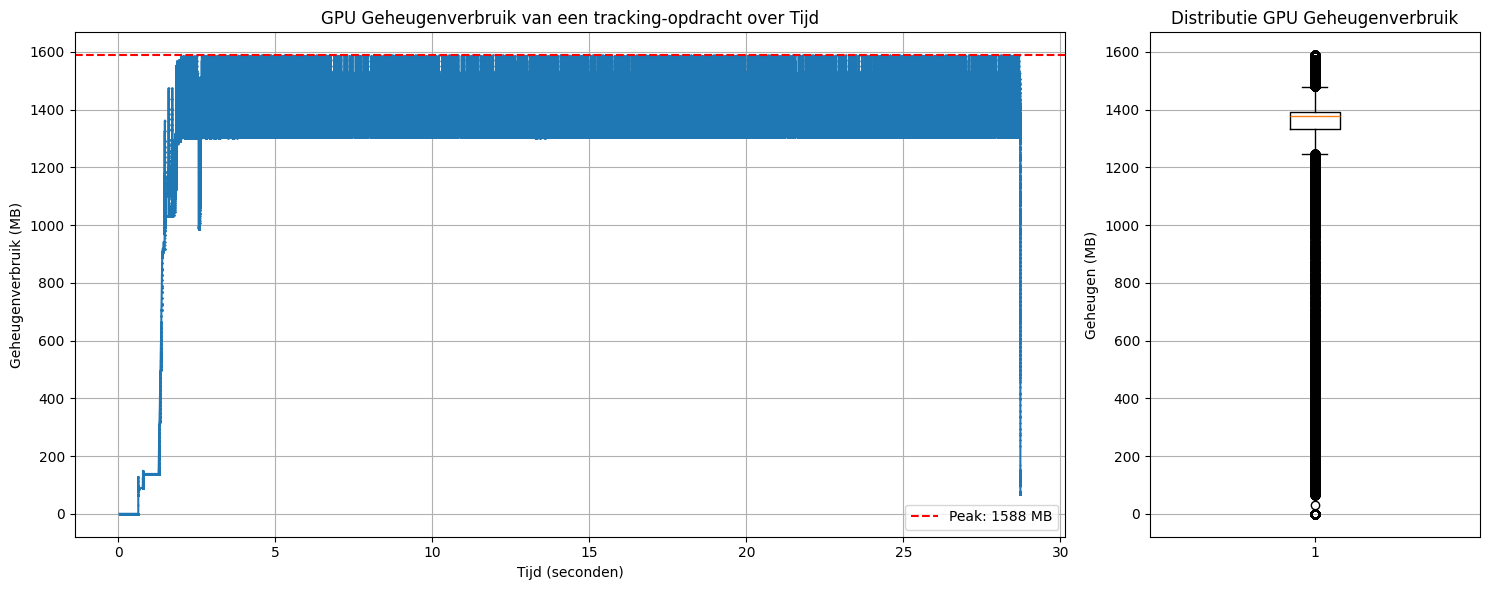

In [12]:
def plot_memory_usage(device, memory_times, cumulative_memory_mb, peak_memory_mb):
    # Plotting the cumulative memory over time
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(15, 6), gridspec_kw={"width_ratios": [3, 1]}
    )

    # Plot cumulative memory in the first subplot
    ax1.plot(memory_times, cumulative_memory_mb, marker=".", linestyle="-", markersize=1)
    ax1.set_title(f"{device} Geheugenverbruik van een tracking-opdracht over Tijd")
    ax1.set_xlabel("Tijd (seconden)")
    ax1.set_ylabel("Geheugenverbruik (MB)")
    ax1.grid(True)

    # Add peak memory annotation
    ax1.axhline(
        y=peak_memory_mb, color="r", linestyle="--", label=f"Peak: {peak_memory_mb} MB"
    )
    ax1.legend()

    # Format x-axis to be more readable
    ax1.ticklabel_format(axis="x")

    # Create boxplot of memory usage in the second subplot
    ax2.boxplot(cumulative_memory_mb)
    ax2.set_title(f"Distributie {device} Geheugenverbruik")
    ax2.set_ylabel("Geheugen (MB)")
    ax2.grid(True, axis="y")

    plt.tight_layout()
    plt.show()


print(f"Total time: {profiling_results['total_time']} seconds")
print(f"Total frames tracked: {profiling_results['total_frames_tracked']}")
print(f"Frames per second: {profiling_results['fps']}")
# print(f"Peak CPU memory usage: {profiling_results['cpu_peak_memory_mb']} MB")
print(f"Peak GPU memory usage: {profiling_results['cuda_peak_memory_mb']} MB")
print(
    f"Mean GPU memory usage: {sum(profiling_results['cuda_cumulative_memory_mb']) / len(profiling_results['cuda_cumulative_memory_mb'])} MB"
)
print(f"\n")

# Extract the relevant data
memory_times = profiling_results["memory_times"]
memory_times = [t * 10 for t in memory_times]  # Convert to seconds

plot_memory_usage(
    "GPU",
    memory_times,
    profiling_results["cuda_cumulative_memory_mb"],
    profiling_results["cuda_peak_memory_mb"],
)
# plot_memory_usage(
#     "CPU",
#     memory_times,
#     profiling_results['cpu_cumulative_memory_mb'],
#     profiling_results['cpu_peak_memory_mb']
# )